In [1]:
from PIL import Image
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import sys
import os
from multiprocessing import Pool
from functools import partial
directory = 'figures'
if not os.path.exists(directory):
    os.makedirs(directory)
from concurrent.futures import ProcessPoolExecutor, as_completed
from dask.distributed import Client, progress
from dask import compute, delayed
import dask.array as da
from dask.diagnostics import ProgressBar
plt.rcParams['figure.dpi']=400

In [2]:
def sparseH(L, J, h, periodic):
    
    """
    generates the sparse Hamiltonian matrix for the quantum Ising chain
    
        Parameters:
            L (int): length of chain
            J (float): ising interaction strength
            h (float): magnetic field strength
            periodic (bool): does the chain have periodic boundary conditions?
            
        Returns:
            H (csr_matrix): sparse matrix representing the Hamiltonian operator
    """
    
    dim = 2 ** L # dimensions of the Hilbert space
    
    # initialize 
    H_data = []
    H_rows = []
    H_cols = []
    
    "Calculation of off-diagonal elements due to the magnetic field"
    
    for beta in range(dim): # iterate over all states
        
        for j in range(1, L + 1): # iterate over all sites
            
            alpha = beta ^ (1 << (j - 1)) # flips jth bit of beta to get the state alpha that is related to beta by a single bit flip
            
            "Keep track of the indices with non-zero matrix elements"
            
            H_data.append(-h)
            H_rows.append(alpha)
            H_cols.append(beta)
    
    "Calculation of diagonal elements due to Ising interaction"

    for alpha in range(dim):  # iterate over all states
        
        A = 0
        
        for j in range(1, L): # iterate over all sites
            
            if 2 * (alpha & (1 << (j - 1))) == alpha & (1 << j): # check if site j and j+1 have the same spin
                
                A -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                A += J # if not, increase the energy by the ising interaction term
                
        "Handling periodic boundary conditions"
                
        if periodic and L > 1: # L > 1 needed for periodicity to mean anything
            
            if (alpha & (1 << (L - 1))) == ((alpha & (1 << 0)) * (2 ** (L - 1))): # Check if the states at either end have the same spin
                
                A -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                A += J # if not, increase the energy by the ising interaction term
        
        if A != 0: # Check if the resulting matrix element is non-zero, if so, keep track of it
        
            H_data.append(A)
            H_rows.append(alpha)
            H_cols.append(alpha)

    H_data = np.array(H_data, dtype=float) # convert the list into a np array
    
    H = scipy.sparse.csr_matrix((H_data, (H_rows, H_cols)), shape=(dim, dim), dtype=np.float64) # make it into a csr sparse matrix
    
    return H

In [3]:
def entanglement_entropy(l, L, J, h, periodic):
    
    H = sparseH(L, J, h, periodic).toarray()
    eigs, vecs = np.linalg.eigh(H)
    vec = vecs[:, np.argmin(np.abs(eigs))]
    
    psi_matrix = vec.reshape((2**l, 2**(L-l)))
    u, s, vh = np.linalg.svd(psi_matrix, compute_uv=True)
    lambdas = s**2
    
    S = -np.sum(lambdas * np.log(lambdas))
    return S

Computing for L=11: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.49it/s]


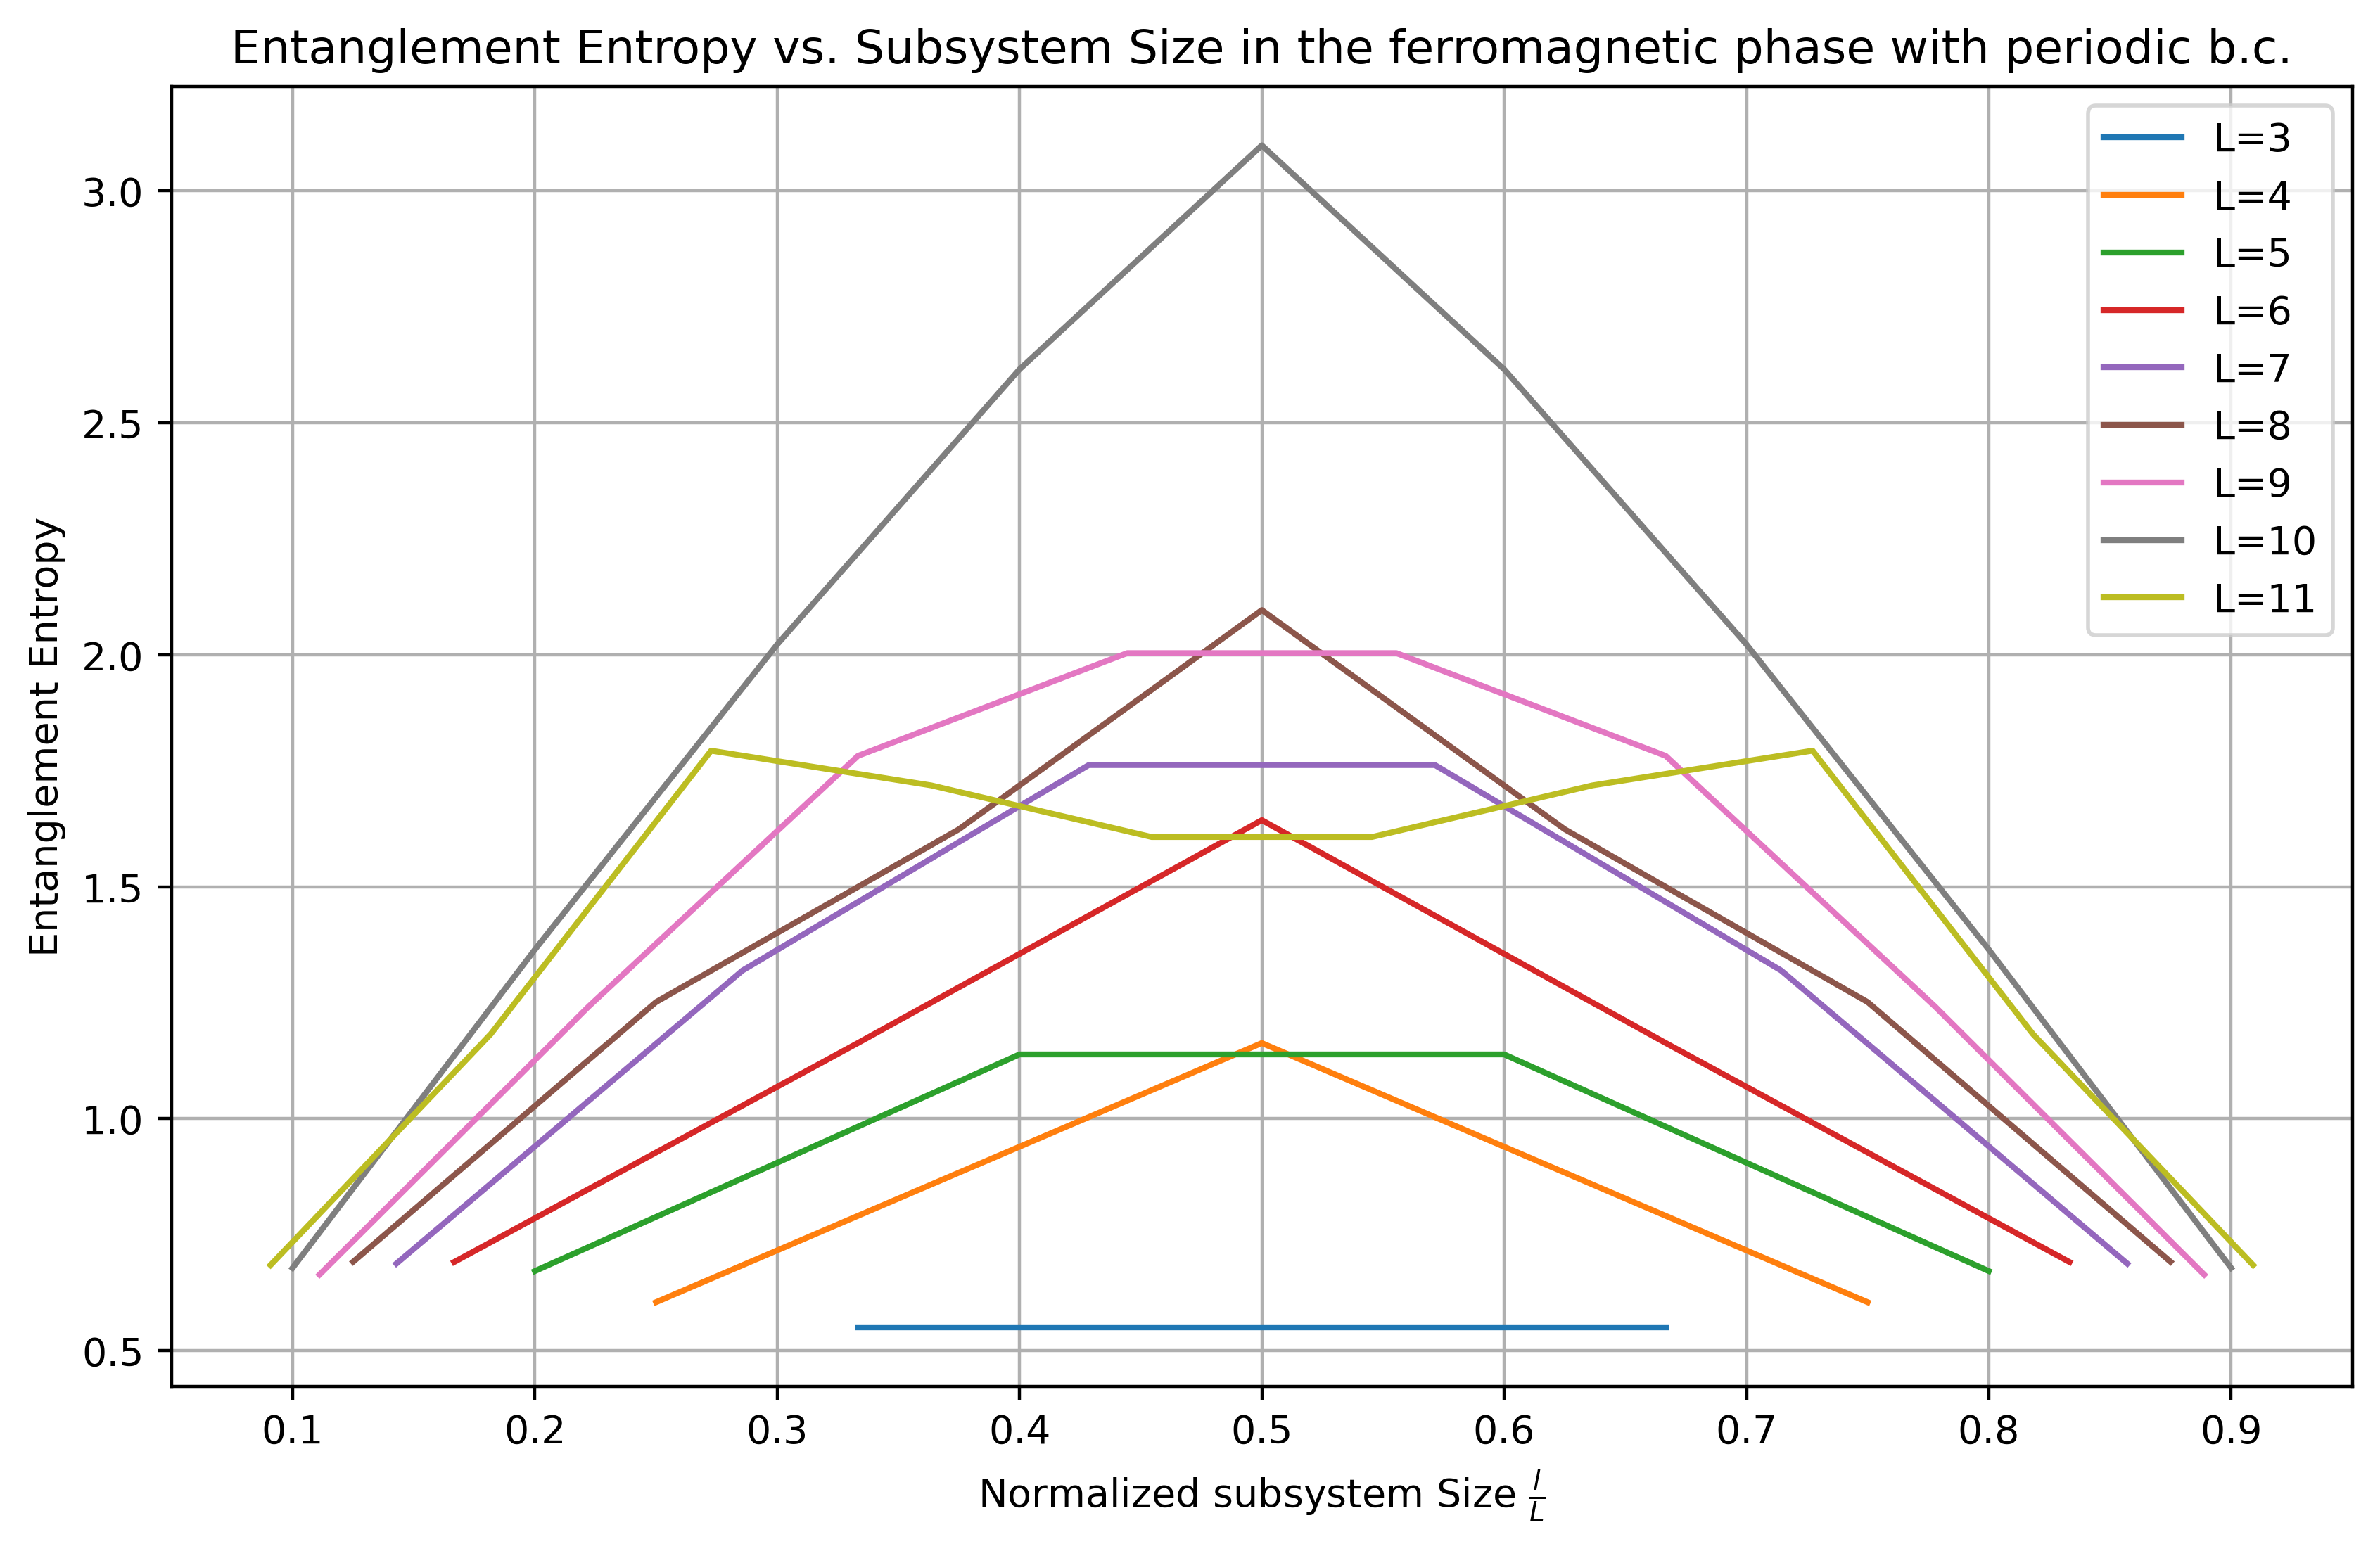

In [27]:
def compute_entropies(L_values, h, periodic):
    results = {}
    for L in L_values:
        ls = range(1, L)
        Entropies = []
        for l in tqdm(ls, desc=f'Computing for L={L}'):
            entropy = entanglement_entropy(l, L, 1, h, periodic)
            Entropies.append(entropy)
        results[L] = Entropies
    return results

def plot_results(results):
    plt.figure(figsize=(10, 6))
    for L, entropies in results.items():
        plt.plot(range(1, L)/np.array(L), entropies, label=f'L={L}')
    plt.xlabel(r'Normalized subsystem Size $\frac{l}{L}$')
    plt.ylabel('Entanglement Entropy')
    plt.title('Entanglement Entropy vs. Subsystem Size in the ferromagnetic phase with periodic b.c.')
    plt.legend()
    plt.grid(True)

L_values = range(3,12)
h = 1.7
periodic = False

entropies = compute_entropies(L_values, h, periodic)
plot_results(entropies)
plt.show()


Calculating Entanglement Entropy:  67%|████████████████████████████████▋                | 8/12 [00:00<00:00, 44.40it/s]

L = 2
L = 3
L = 4
L = 5
L = 6
L = 7
L = 8
L = 9
L = 10
L = 11
L = 12


Calculating Entanglement Entropy: 100%|████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.77s/it]

L = 13


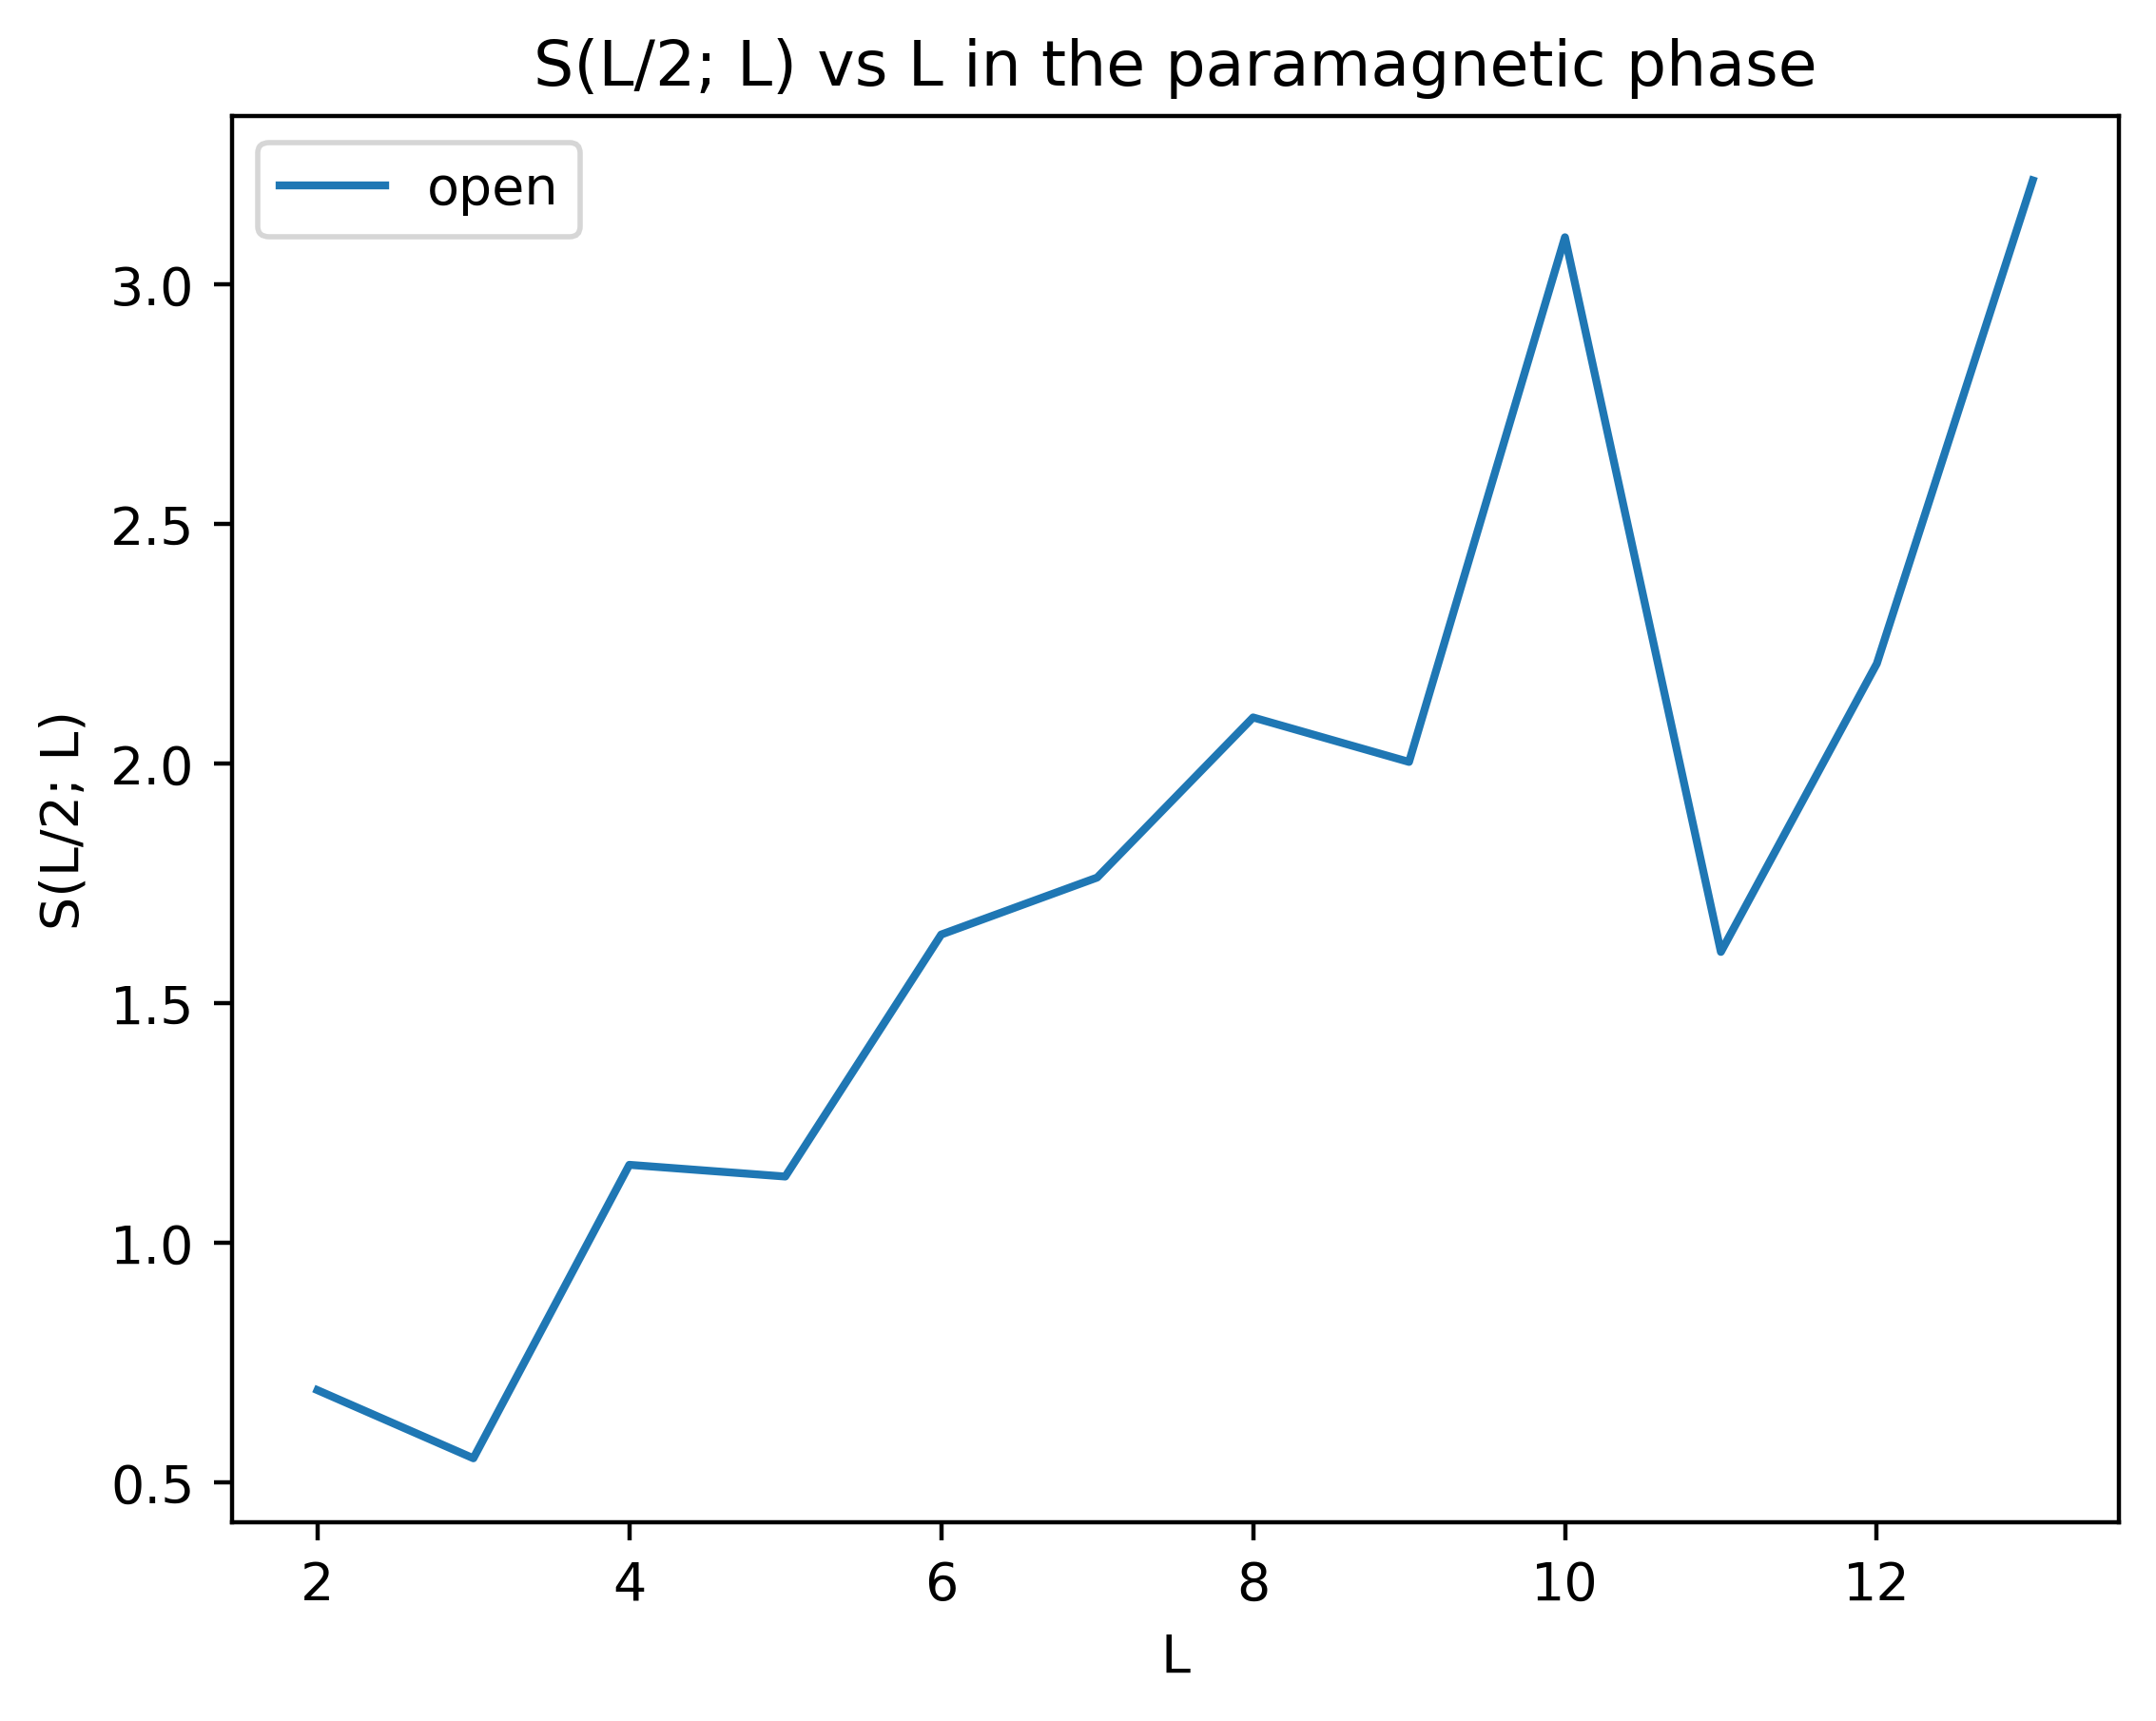

In [4]:
L_values = range(2, 14)
h = 1.7
Eopen=[]

for L in tqdm(L_values, desc='Calculating Entanglement Entropy'):
        Eopen.append(entanglement_entropy(L//2, L, 1, h, False))
        print('L =', L)
        
plt.plot(L_values, Eopen, label='open')
plt.xlabel('L')
plt.ylabel('S(L/2; L)')
plt.title('S(L/2; L) vs L in the paramagnetic phase')

plt.legend()
plt.show()